In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import re

In [74]:
df = pd.read_csv('https://raw.githubusercontent.com/rsw0/forest-biomass-china/main/forest-biomass-china.csv')

# Train Test Split

In [75]:
# Consider AGBt as the response variable, drop all rows (if any) where the response variable is NaN, because we can't predict nor inpute NaN response
df = df[df['AGBt'].notna()]
# note that no rows were removed since all rows of AGBt are not NaN. Can be checked using df.shape
seed = 0
X_train, X_validation, y_train, y_validation = train_test_split(df.drop(['AGBt'], axis=1), df['AGBt'], test_size=0.2, random_state=seed)

# Preprocessing 1

### Typecasting

In [76]:
print('Before typecasting:')
print(X_train.dtypes)
print(y_train.dtypes)
def typecasting(df):
    """
    Stnad_density, Plot_dimension, Sample_size, and Tree_numbers are documented as int in the metadata
    However, since they contain NaN values, they cannot be converted to int directly using astype()
    They can only take the type float, as NaN has type float
    --------------------------------------------------------
    Stand_age and MMD contain special values (strings). More information from the metadata is included below

    Stand_age:
    In China, the age of a natural forest is generally defined as age since germination, and the age of a planted 
    forest is defined as age since planting. Stand age is usually obtained from historical records, or counting 
    tree rings from core samples of dominant tree species. Stand descriptions from original studies indicated that 
    trees of all-ages represented some natural forests, i.e., trees of all age classes (young to mature or overmature), 
    particularly primary forests. Therefore, stand age for these forests were denoted as 'All-aged' in the column 
    'Stand age' in our data set.

    MMD:
    According to the descriptions of stand measurement, the vast majority of original studies measured all trees 
    higher than breast height (1.3 m) within plots, and thus did not employ specified MMD values. In these studies 
    MMD values actually referred to the minimum DBH of trees higher than breast height. Therefore, MMD values in 
    these studies were denoted as 'Min DBH' in the column 'MMD' of our data set. 
    """
    df['Stand_age'] = df['Stand_age'].replace('All-aged',np.NaN)
    df['MMD'] = df['MMD'].replace('Min DBH',np.NaN)
    df = df.astype({'MAP': float, 'Stand_age': float, 'MMD': float})
    return df

X_train = typecasting(X_train)
print()
print()
print()
print('After typecasting')
print(X_train.dtypes)

Before typecasting:
ID                      int64
Province               object
Study_site             object
Latitude              float64
Longitude             float64
Altitude                int64
MAT                   float64
MAP                     int64
Soil_fertility         object
Forest_type            object
Dominant_species       object
Stand_origin           object
Stand_age              object
MMD                    object
Mean_DBH              float64
Mean_height           float64
Stand_density         float64
GSV                   float64
Plot_dimension        float64
Sample_size           float64
Method                 object
Tree_numbers          float64
Trees                 float64
Wood                  float64
Bark                  float64
Stem                  float64
Branch                float64
Leaf                  float64
Crown                 float64
Reproduction          float64
BGBt                  float64
Understory            float64
AGBu                

### Missing Data

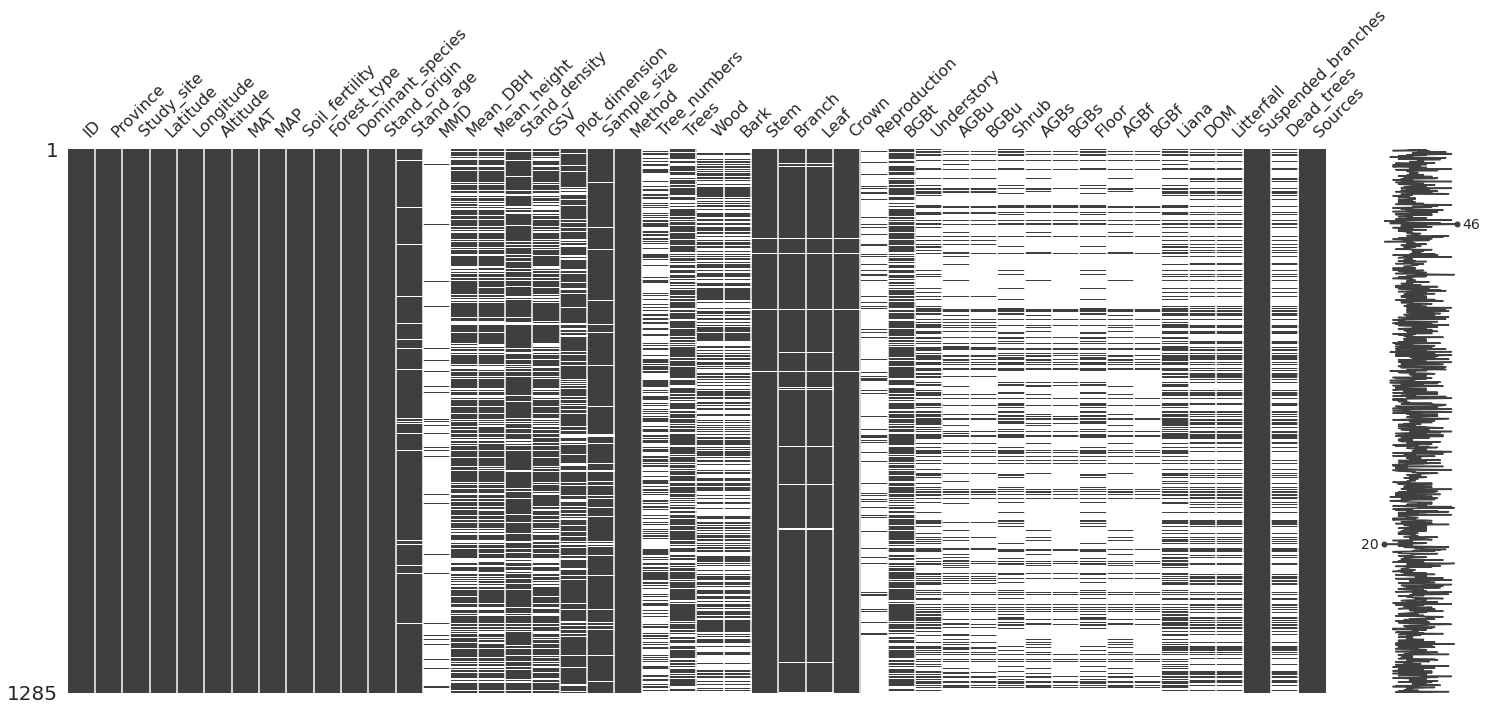

ID                       0
Province                 0
Study_site               0
Latitude                 0
Longitude                0
Altitude                 0
MAT                      0
MAP                      0
Soil_fertility           0
Forest_type              0
Dominant_species         0
Stand_origin             0
Stand_age               40
MMD                   1232
Mean_DBH               385
Mean_height            405
Stand_density          240
GSV                    381
Plot_dimension         289
Sample_size             95
Method                   0
Tree_numbers           785
Trees                  368
Wood                   623
Bark                   623
Stem                    10
Branch                  46
Leaf                    46
Crown                   10
Reproduction          1130
BGBt                   368
Understory             789
AGBu                  1009
BGBu                  1066
Shrub                  951
AGBs                  1058
BGBs                  1121
F

In [77]:
def draw_na_chart(df):
    na_chart = msno.matrix(df)
    na_chart_copy = na_chart.get_figure()
    plt.show()
    na_count = df.isna().sum()
    print(na_count)
    return na_count
na_count_output = draw_na_chart(X_train)

In [78]:
# dropping features where more than 80% of the dataset are NAs
na_cutoff = X_train.shape[0]*0.1
dropped_columns = list(na_count_output[na_count_output > na_cutoff].index)
def remove_80(df):
    df = df.drop(columns = dropped_columns)
    na_count = df.isna().sum()
    print(na_count)
    return df
X_train = remove_80(X_train)

ID                     0
Province               0
Study_site             0
Latitude               0
Longitude              0
Altitude               0
MAT                    0
MAP                    0
Soil_fertility         0
Forest_type            0
Dominant_species       0
Stand_origin           0
Stand_age             40
Sample_size           95
Method                 0
Stem                  10
Branch                46
Leaf                  46
Crown                 10
Suspended_branches     0
Sources                0
dtype: int64


In [79]:
# dropping features that are redundant/not useful based on the metadata
dropped_columns1 = ['ID', 'Province', 'Study_site', 'Sample_size', 'Method', 'Sources']
def remove_useless(df):
    df = df.drop(columns = dropped_columns1)
    na_count = df.isna().sum()
    print(na_count)
    return df
X_train = remove_useless(X_train)

Latitude               0
Longitude              0
Altitude               0
MAT                    0
MAP                    0
Soil_fertility         0
Forest_type            0
Dominant_species       0
Stand_origin           0
Stand_age             40
Stem                  10
Branch                46
Leaf                  46
Crown                 10
Suspended_branches     0
dtype: int64


### Inputation

In [80]:
def impute(df):
    # NOTE! Did median impute, as it is more robust to outliers and skewed distributions
    continuous_columns = ['Latitude', 'Longitude', 'Altitude', 'MAT', 'MAP', 'Stand_age', 'Stem', 'Branch', 'Leaf', 'Crown', 'Suspended_branches']
    median_list = []
    print(df.shape)
    for col_name in continuous_columns:
        median = df[col_name].median()
        df[col_name] = df[col_name].fillna(median)
        median_list.append((col_name,median))
    print(df.shape)
    return df, median_list

X_train, median_list = impute(X_train)
print(X_train.isna().sum())

(1285, 15)
(1285, 15)
Latitude              0
Longitude             0
Altitude              0
MAT                   0
MAP                   0
Soil_fertility        0
Forest_type           0
Dominant_species      0
Stand_origin          0
Stand_age             0
Stem                  0
Branch                0
Leaf                  0
Crown                 0
Suspended_branches    0
dtype: int64


### Inconsistency (Duplicates)

In [81]:
dup_bool = X_train.duplicated().to_numpy()
np.any(dup_bool)
dup_list = []
for i in range(len(dup_bool)):
    if dup_bool[i]:
        dup_list.append(i)
def dup_drop(df):
    for i in dup_list:
        df = df.drop(index=i)
    return df
X_train = dup_drop(X_train)
y_train = dup_drop(y_train)

# EDA

### Scatterplot Matrix

In [82]:
sns.set_theme(style="ticks")
# train_df combines X and y
train_df = X_train.copy()
train_df['AGBt'] = y_train
print(train_df.shape)
# excluding four outliers for better visualization
train_df = train_df[train_df['AGBt'] < 500]
print(train_df.shape)
#sns.pairplot(train_df[['Latitude', 'Longitude', 'Altitude', 'MAT', 'MAP', 'Stand_age', 'Stem', 'Branch', 'Leaf', 'Crown', 'Suspended_branches', 'AGBt']])

(1284, 16)
(1280, 16)


Note:
1. Potential outliers in dataset, resulting the weird-looking histograms on the diagonals
2. multicolinearity: latitude-(MAT, MAP), MAT-MAP, Branch-Crown
3. some predictors and response appears to be linearly correlated, while others are not, suggesting potential non-linear models

### Class Distributions

In [83]:
for col in X_train[['Soil_fertility', 'Forest_type', 'Dominant_species', 'Stand_origin']]:
    print(X_train[col].value_counts())
    print()
    print('--------------------------------------------------------------------------------------------------')

III    565
II     270
V      217
I      130
IV     102
Name: Soil_fertility, dtype: int64

--------------------------------------------------------------------------------------------------
Pinus forest                               302
Cunninghamia forest                        264
Larix forest                                93
Eucalyptus forest                           77
Populus forest                              66
Cunninghamia & broadleaved mixed forest     53
Pinus & broadleaved mixed forest            37
Quercus forest                              32
Picea forest                                32
Fokienia forest                             27
Acacia forest                               25
Castanopsis forest                          24
Robinia forest                              22
Evergreen broadleaved mixed forest          20
Metasequoia forest                          17
Betula forest                               17
Cupressus forest                            16
Evergreen c

Note:
1. Soil Fertility seems to be roughly evenly distributed, which is good because we don't need resampling techniques for classifiers to be useful
2. The distribution of other categorical variable suggest we should look perform ANOVA and Tukey's HSD on them to potentially reduce them to binary variables

# Preprocessing 2

### Transformations

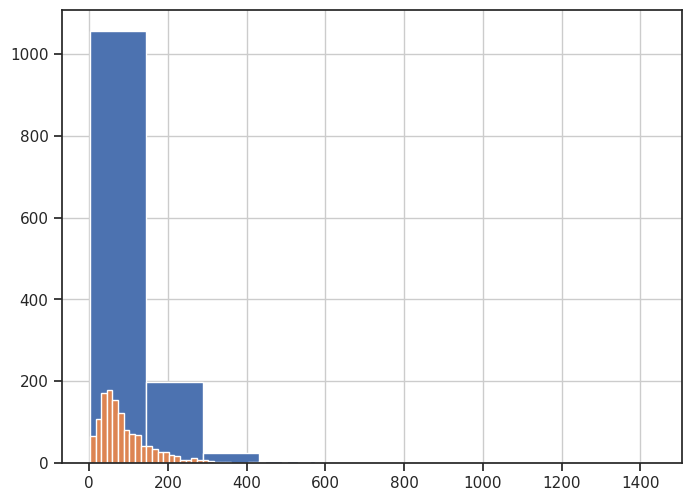

In [84]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
y_train.hist()
y_train.hist(bins=100)

Note:
1. potential outliers present
2. skewed y

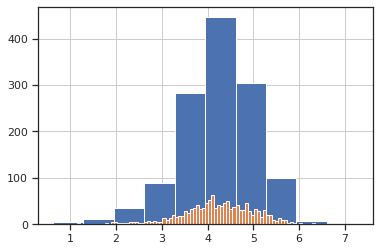

In [85]:
def log_trans(col_name):
    return np.log(col_name)
y_train_log = log_trans(y_train)
y_train_log.hist()
y_train_log.hist(bins=100)

### Outliers & Winsorizing

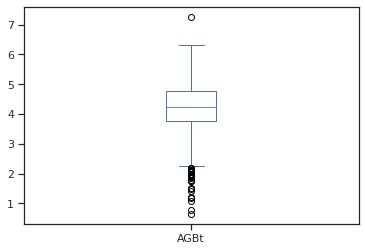

In [86]:
y_train_log.plot.box()

In [87]:
def detect_outliers_iqr(vec):
    outliers = []
    vec = sorted(vec)
    q1 = np.percentile(vec, 25)
    q3 = np.percentile(vec, 75)
    print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print(lwr_bound, upr_bound)
    for i in range(len(vec)): 
        if (vec[i]<lwr_bound or vec[i]>upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound

outliers, lwr_bound, upr_bound = detect_outliers_iqr(y_train_log)
print("Outliers from IQR method: ", outliers)
print(len(outliers))

3.759396118160845 4.784528812846478
2.2216970761323953 6.322227854874928
Outliers from IQR method:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1283]
30


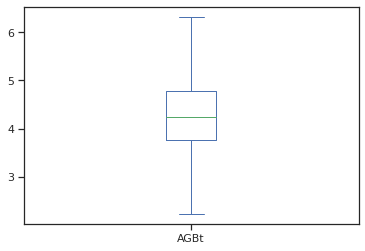

In [88]:
''' 
note that this pandas series where method is different from np.where
the first argument is a condition. If the condition evaluates to True
then the value of that particular entry is not change
If the condition evaluates to false, then replace that value with the
second parameter 
'''
y_train_log = y_train_log.where(y_train_log < upr_bound, upr_bound)
y_train_log = y_train_log.where(y_train_log > lwr_bound, lwr_bound)
y_train_log.plot.box()

### Standardization

In [89]:
# It doesn't make sense to mean-center geo features and dividing by variance, 
# so we simply scale to within the same range as the standard scaler

std_scaler = preprocessing.StandardScaler()
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
standardize_columns = ['MAT', 'MAP', 'Stand_age', 'Stem', 'Branch', 'Leaf', 'Crown', 'Suspended_branches']
minmax_columns = ['Latitude', 'Longitude', 'Altitude']
categorical_columns = ['Soil_fertility', 'Forest_type', 'Dominant_species', 'Stand_origin']
# note that fit_transform retains the fit, so we can directly transform test set later by calling transform
# see here:
# https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models
X_train[standardize_columns] = std_scaler.fit_transform(X_train[standardize_columns])
X_train[minmax_columns] = minmax_scaler.fit_transform(X_train[minmax_columns])

# Feature Selection for AGBt

### PCA

In [90]:
pca_train = PCA(n_components=2)
# Similar as before, fit_transform stores the fit internally, so that we can call it later
X_train_biomass_pca = pca_train.fit_transform(X_train[['Stem', 'Branch', 'Leaf', 'Crown']])
print(pca_train.explained_variance_ratio_)
print(pca_train.singular_values_)
print(pca_train.components_)
print(X_train_biomass_pca)

[0.70967577 0.18837346]
[60.37296378 31.10443808]
[[ 0.47019545  0.54191998  0.38682142  0.57931698]
 [-0.4315073  -0.28096348  0.85624377  0.04132291]]
[[-0.93695206 -0.00787046]
 [-0.09562855  0.72748543]
 [-1.21655843  0.19599395]
 ...
 [-0.33551225  0.770831  ]
 [-0.08517974 -0.54370381]
 [-0.48264945  0.33010632]]


In [91]:
def replace_with_pca(df, pca_comp):
    # keep original features, select in R
    # df = df.drop(columns = ['Stem', 'Branch', 'Leaf', 'Crown'])
    df = df.reset_index(drop=True)
    pca_comp_df = pd.DataFrame(pca_comp, columns = ['pca_0', 'pca_1'])
    df = df.join(pca_comp_df)
    return df

X_train = replace_with_pca(X_train, X_train_biomass_pca)

### Random Forest Feature Importance

Feature: 0, Score: 0.10075
Feature: 1, Score: 0.07168
Feature: 2, Score: 0.09046
Feature: 3, Score: 0.07490
Feature: 4, Score: 0.17052
Feature: 5, Score: 0.47559
Feature: 6, Score: 0.01611


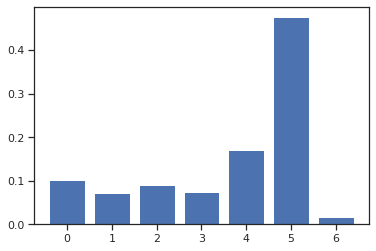

<Figure size 432x288 with 0 Axes>

In [92]:
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train[['Latitude', 'Longitude', 'Altitude', 'MAT', 'MAP', 'Stand_age', 'Suspended_branches']], y_train_log)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()
plt.savefig('rf_feature_importance.png', dpi=300)

In [93]:
def remove_suspended_branch(df):
    df = df.drop(columns = ['Suspended_branches'])
    return df
X_train = remove_suspended_branch(X_train)

### Categorical Collapse

In [94]:
for elem in categorical_columns:
    print(X_train[elem].value_counts())
    print(X_train[elem].nunique())
print(X_train['Dominant_species'].value_counts())

III    565
II     270
V      217
I      130
IV     102
Name: Soil_fertility, dtype: int64
5
Pinus forest                               302
Cunninghamia forest                        264
Larix forest                                93
Eucalyptus forest                           77
Populus forest                              66
Cunninghamia & broadleaved mixed forest     53
Pinus & broadleaved mixed forest            37
Quercus forest                              32
Picea forest                                32
Fokienia forest                             27
Acacia forest                               25
Castanopsis forest                          24
Robinia forest                              22
Evergreen broadleaved mixed forest          20
Metasequoia forest                          17
Betula forest                               17
Cupressus forest                            16
Evergreen coniferous mixed forest           16
Deciduous broadleaved mixed forest          15
Casuarina fores

In [95]:
def forest_collapse(df):
    forest_list = df['Forest_type'].to_numpy()
    for i in range(len(forest_list)):
        if forest_list[i] not in ['Pinus forest', 'Cunninghamia forest', 'Larix forest', 'Eucalyptus forest', 'Populus forest']:
            forest_list[i] = 'Other'
    df['Forest_type'] = forest_list
    return df
X_train = forest_collapse(X_train)

def species_collapse(df):
    species_list = df['Dominant_species'].to_numpy()
    for i in range(len(species_list)):
        if species_list[i] not in ['C. lanceolata', 'P. tabuliformis', 'P. massoniana', 'P. koraiensis', 'L. gmelinii']:
            species_list[i] = 'Other'
    df['Dominant_species'] = species_list
    return df
X_train = species_collapse(X_train)

### One-Hot Encoding

In [96]:
def categorical_onehot(df, col_list):
    for original_col_name in col_list:
        dummy_df = pd.get_dummies(df[original_col_name])
        old_col_names = dummy_df.columns
        new_col_names = []
        for elem in old_col_names:
            if elem == 'Other':
                new_col_names.append(elem+'_'+original_col_name)
            else:
                new_col_names.append(elem.replace(" ", "_"))
        rename_dict = dict(zip(old_col_names, new_col_names))
        # keeping the original column as output, for Tukey HSD in R
        # df = df.drop(columns = [original_col_name])
        df = df.join(dummy_df)
        df = df.rename(columns=rename_dict)
    return df
X_train = categorical_onehot(X_train, categorical_columns)

### Applying the same transformations above to the validation set

In [97]:
X_validation = typecasting(X_validation)
X_validation = remove_80(X_validation)
X_validation = remove_useless(X_validation)

# impute should use the median obtained from training
def impute_validation(df, median_list):
    # NOTE! Did median impute, as it is more robust to outliers and skewed distributions
    print(df.shape)
    for i in range(len(median_list)):
        df[median_list[i][0]] = df[median_list[i][0]].fillna(median_list[i][1])
    print(df.shape)
    return df
X_validation = impute_validation(X_validation, median_list)

# standardization of test set should also use the scaler obtained by fitting on the training set
# see here:
# https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
X_validation[standardize_columns] = std_scaler.transform(X_validation[standardize_columns])
X_validation[minmax_columns] = minmax_scaler.transform(X_validation[minmax_columns])

# PCA on the test set should also use the subspace obtained by performing PCA on training
# we are projecting testing onto training's subspace
# see here:
# https://stats.stackexchange.com/questions/55718/pca-and-the-train-test-split
# and here:
# https://stats.stackexchange.com/questions/142216/zero-centering-the-testing-set-after-pca-on-the-training-set
X_validation_biomass_pca = pca_train.transform(X_validation[['Stem', 'Branch', 'Leaf', 'Crown']])
X_validation = replace_with_pca(X_validation, X_validation_biomass_pca)

X_validation = remove_suspended_branch(X_validation)
y_validation_log = log_trans(y_validation)
X_validation = forest_collapse(X_validation)
X_validation = species_collapse(X_validation)
X_validation = categorical_onehot(X_validation, categorical_columns)

ID                     0
Province               0
Study_site             0
Latitude               0
Longitude              0
Altitude               0
MAT                    0
MAP                    0
Soil_fertility         0
Forest_type            0
Dominant_species       0
Stand_origin           0
Stand_age             12
Sample_size           19
Method                 0
Stem                   4
Branch                12
Leaf                  12
Crown                  4
Suspended_branches     0
Sources                0
dtype: int64
Latitude               0
Longitude              0
Altitude               0
MAT                    0
MAP                    0
Soil_fertility         0
Forest_type            0
Dominant_species       0
Stand_origin           0
Stand_age             12
Stem                   4
Branch                12
Leaf                  12
Crown                  4
Suspended_branches     0
dtype: int64
(322, 15)
(322, 15)


### Write training and validation dataframes to csv

In [98]:
print(X_train.shape)
print(y_train.shape)

(1284, 36)
(1284,)


In [99]:
train_df_combined = X_train.copy()
y_train_log = y_train_log.reset_index(drop=True)
train_df_combined['AGBt'] = y_train_log
validation_df_combined = X_validation.copy()
y_validation_log = y_validation_log.reset_index(drop=True)
validation_df_combined['AGBt'] = y_validation_log
train_df_combined.to_csv('train.csv', index=False)
validation_df_combined.to_csv('validation.csv', index=False)

In [100]:
print(train_df_combined.columns)
print(validation_df_combined.columns)
print(train_df_combined.shape)
print(validation_df_combined.shape)

Index(['Latitude', 'Longitude', 'Altitude', 'MAT', 'MAP', 'Soil_fertility',
       'Forest_type', 'Dominant_species', 'Stand_origin', 'Stand_age', 'Stem',
       'Branch', 'Leaf', 'Crown', 'pca_0', 'pca_1', 'I', 'II', 'III', 'IV',
       'V', 'Cunninghamia_forest', 'Eucalyptus_forest', 'Larix_forest',
       'Other_Forest_type', 'Pinus_forest', 'Populus_forest', 'C._lanceolata',
       'L._gmelinii', 'Other_Dominant_species', 'P._koraiensis',
       'P._massoniana', 'P._tabuliformis', 'Planted', 'Primary', 'Secondary',
       'AGBt'],
      dtype='object')
Index(['Latitude', 'Longitude', 'Altitude', 'MAT', 'MAP', 'Soil_fertility',
       'Forest_type', 'Dominant_species', 'Stand_origin', 'Stand_age', 'Stem',
       'Branch', 'Leaf', 'Crown', 'pca_0', 'pca_1', 'I', 'II', 'III', 'IV',
       'V', 'Cunninghamia_forest', 'Eucalyptus_forest', 'Larix_forest',
       'Other_Forest_type', 'Pinus_forest', 'Populus_forest', 'C._lanceolata',
       'L._gmelinii', 'Other_Dominant_species', 'P._kor

In [101]:
validation_df_combined.isna().sum()

Latitude                  0
Longitude                 0
Altitude                  0
MAT                       0
MAP                       0
Soil_fertility            0
Forest_type               0
Dominant_species          0
Stand_origin              0
Stand_age                 0
Stem                      0
Branch                    0
Leaf                      0
Crown                     0
pca_0                     0
pca_1                     0
I                         0
II                        0
III                       0
IV                        0
V                         0
Cunninghamia_forest       0
Eucalyptus_forest         0
Larix_forest              0
Other_Forest_type         0
Pinus_forest              0
Populus_forest            0
C._lanceolata             0
L._gmelinii               0
Other_Dominant_species    0
P._koraiensis             0
P._massoniana             0
P._tabuliformis           0
Planted                   0
Primary                   0
Secondary           


# LASSO and Tukey HSD will be performed in R

# R csv output is the final output

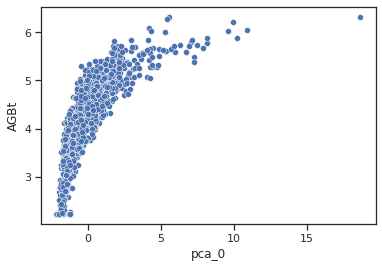

In [102]:
sns.scatterplot(x='pca_0', y='AGBt', data=train_df_combined)

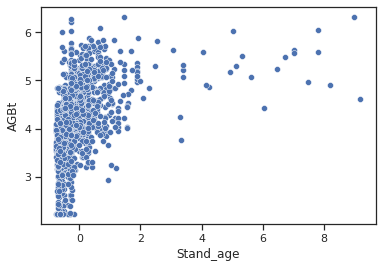

In [103]:
sns.scatterplot(x='Stand_age', y='AGBt', data=train_df_combined)